In [227]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

In [228]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 2 + 1 + 1 + 2)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 2 + 1 + 1 + 2))
        new_data[0, 0:2] = state
        new_data[0, 2:4] = [action, reward]
        if not done:
            new_data[0, 4:] = next_state 
        else:
            new_data[0, 4:] = [np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [229]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 64)
        self.b1 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(64, 64)
        self.b2 = nn.BatchNorm1d(64)
        self.l3 = nn.Linear(64, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.b1(self.l1(x)))
        x = F.relu(self.b2(self.l2(x)))
        x = self.l3(x)
        return x

In [242]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.8):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('epoch')
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();

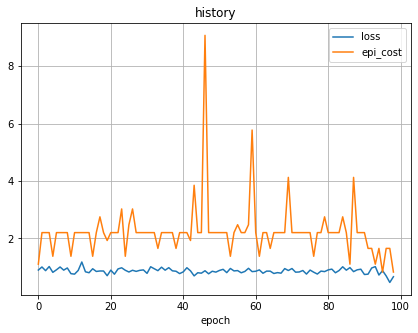

In [283]:
## This block is for training the dq stepper
buffer_size = 80
buffer = Buffer(buffer_size)

dqs = DQStepper(lr=1e-4)
batch_size = 16
epsillon = 0.2

e = 1
no_epi = 100
no_steps = 20 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [0, 0, 5])

history = {'loss':[], 'epi_cost':[]}

while e < no_epi:
    state = env.reset_env([0.0, 0], no_steps*step_time)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
        history['loss'].append(loss)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

In [302]:
## this block is to test the trained dq stepper
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken

state = env.reset_env([0.0, 0], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action, q_value)
    next_state, cost, done = env.step_env(action, step_time)
    state = next_state
    epi_cost += cost
    if done:
        print(epi_cost)
        break
print("showing simulation...")    
#env.show_episode(10, 1)

5 [0.20110288]
5 [0.20110273]
5 [0.2011027]
0.8250000000000004
showing simulation...


2
2
